In [29]:
from hdc import *
import numpy as np
import cupy as cp
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [30]:
COS_SIM_THRESHOLD = 0.075
RNG = np.random.default_rng()

In [31]:
if cp.cuda.is_available():
# if cp.cuda.is_available() and False:
    device_marker = cp.empty(1)
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    device_marker = np.empty(1)
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    
xp = cp.get_array_module(device_marker)
print(f'xp = {xp.__name__}')

xp = cupy


In [32]:
hdc = Hdc(10000, xp)

In [33]:
x1 = hdc()
x2 = hdc()
(x1 == x2).sum(), hdc.absdist(x1, x2), hdc.reldist(x1, x2), hdc.sim(x1, x2)

(array(5012), array(4988), array(0.4988), array(0.0024))

In [34]:
for _ in range(1000):
    x1 = hdc()
    x2 = hdc()
    s = hdc.sim(x1, x2)
    assert s < COS_SIM_THRESHOLD
    assert np.isclose(hdc.normalize(x1) @ hdc.normalize(x2), s)

In [35]:
xs1 = hdc(10)
xs2 = hdc(10)
xs1_norm = hdc.normalize(xs1)
xs2_norm = hdc.normalize(xs2)

for i, x_pair in enumerate(zip(xs1, xs2)):
    s = hdc.sim(x_pair[0], x_pair[1])
    assert s < COS_SIM_THRESHOLD
    assert np.isclose(xs1_norm[i] @ xs2_norm[i], s)    

In [36]:
b = hdc.bundle_noties(x1, x2)
x1, x2, b, hdc.absdist(x1, b), hdc.absdist(x2, b), hdc.reldist(x1, b), hdc.reldist(x2, b), hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1, -1, -1, ...,  1, -1, -1], dtype=int8),
 array([-1,  1, -1, ...,  1, -1, -1], dtype=int8),
 array([-1,  0, -1, ...,  1, -1, -1], dtype=int8),
 array(4944),
 array(4944),
 array(0.4944),
 array(0.4944),
 array(0.71105555),
 array(0.71105555))

In [37]:
for _ in range(1000):
    b = hdc.bundle_noties(x1, x2)
    assert hdc.sim(x1, b) > COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) > COS_SIM_THRESHOLD

In [38]:
b = hdc.bundle_ties(x1, x2)
x1, x2, b, hdc.absdist(x1, b), hdc.absdist(x2, b), hdc.reldist(x1, b), hdc.reldist(x2, b), hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1, -1, -1, ...,  1, -1, -1], dtype=int8),
 array([-1,  1, -1, ...,  1, -1, -1], dtype=int8),
 array([-1, -1, -1, ...,  1, -1, -1], dtype=int8),
 array(2473),
 array(2471),
 array(0.2473),
 array(0.2471),
 array(0.5054),
 array(0.5058))

In [39]:
for _ in range(1000):
    b = hdc.bundle_ties(x1, x2)
    assert hdc.sim(x1, b) > COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) > COS_SIM_THRESHOLD

In [40]:
assert hdc.sim(x1, hdc.bundle_noties(x1, x2)) > COS_SIM_THRESHOLD

In [41]:
b = hdc.bind(x1, x2)
x1, x2, b, hdc.reldist(x1, b), hdc.reldist(x2, b), hdc.reldist(x1, x2), hdc.sim(x1, b), hdc.sim(x2, b)

(array([-1, -1, -1, ...,  1, -1, -1], dtype=int8),
 array([-1,  1, -1, ...,  1, -1, -1], dtype=int8),
 array([ 1, -1,  1, ...,  1,  1,  1], dtype=int8),
 array(0.5009),
 array(0.5009),
 array(0.4944),
 array(-0.0018),
 array(-0.0018))

In [42]:
for _ in range(1000):
    b = hdc.bind(x1, x2)
    assert hdc.sim(x1, b) < COS_SIM_THRESHOLD
    assert hdc.sim(x2, b) < COS_SIM_THRESHOLD

In [43]:
s = hdc.shift(x1)
x1, s, hdc.absdist(x1, s), hdc.reldist(x1, s), hdc.sim(x1, s)

(array([-1, -1, -1, ...,  1, -1, -1], dtype=int8),
 array([-1, -1, -1, ..., -1,  1, -1], dtype=int8),
 array(5044),
 array(0.5044),
 array(-0.0088))

In [44]:
for _ in range(1000):
    s = hdc.shift(x1)
    assert hdc.sim(x1, s) < COS_SIM_THRESHOLD

In [45]:
m = hdc(3)
m, hdc.bundle_noties(m)

(array([[ 1,  1,  1, ...,  1, -1,  1],
        [ 1, -1, -1, ...,  1,  1, -1],
        [ 1, -1,  1, ..., -1,  1, -1]], dtype=int8),
 array([ 1, -1,  1, ...,  1,  1, -1], dtype=int8))

In [46]:
for _ in tqdm(range(128*128)):
    xs = hdc(3)
    x1 = xs[0]
    x2 = xs[1]
    x3 = xs[2]
    assert np.array_equal(hdc.bind(x1, hdc.bundle_noties(x2, x3)), hdc.bundle_noties(hdc.bind(x1, x2), hdc.bind(x1, x3)))
    assert np.isclose(hdc.sim(x1, x2), hdc.sim(hdc.bind(x1, x3), hdc.bind(x2, x3)))
    assert np.isclose(hdc.sim(x1, x2), hdc.sim(hdc.shift(x1), hdc.shift(x2)))

  0%|          | 0/16384 [00:00<?, ?it/s]

In [47]:
x1 = hdc()
bundle = hdc.bundle([x1])
assert np.array_equal(x1, bundle)

In [48]:
hdv1 = hdc.normalize(hdc())
hist = None
trials = 100

for _ in tqdm(range(trials)):
    other_hdvs = hdc.normalize(hdc(10000))
    cos_sims = other_hdvs @ hdv1
    cos_sims *= 100
    h = np.histogram(cos_sims, bins=list(range(-10, 10 + 1, 1)))
    hist = h[0] if hist is None else hist + h[0]

  0%|          | 0/100 [00:00<?, ?it/s]

In [49]:
df = pd.DataFrame(columns=['Range', 'Count', '%'])
df['Range'] = list(map(lambda pair: f'{pair[0]:6.2f}, {pair[1]:6.2f}', (zip(h[1]/100, h[1][1:]/100))))
df['Count'] = xp_array_from_gpu(hist)
df['%'] = list(map(lambda p: f'{p*100:.4f}%', hist / (np.sum(hist))))
df

,Range,Count,%
0,"-0.10, -0.09",0,0.0000%
1,"-0.09, -0.08",0,0.0000%
2,"-0.08, -0.07",0,0.0000%
3,"-0.07, -0.06",0,0.0000%
4,"-0.06, -0.05",0,0.0000%
5,"-0.05, -0.04",30,0.0030%
6,"-0.04, -0.03",1379,0.1379%
7,"-0.03, -0.02",21299,2.1299%
8,"-0.02, -0.01",136264,13.6264%
9,"-0.01, 0.00",340956,34.0956%


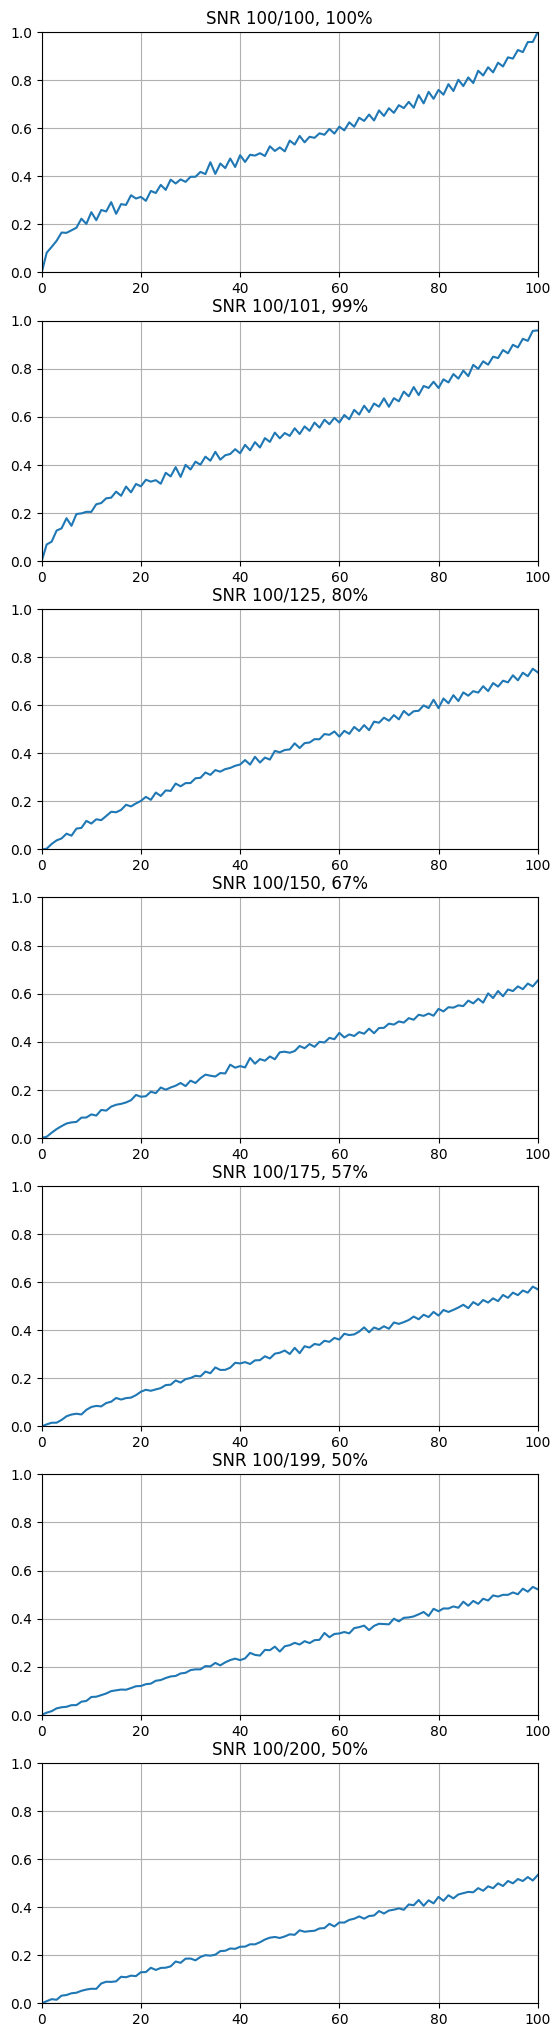

In [50]:
signal_hdvs = hdc(100)
signal_points = list(range(0, signal_hdvs.shape[0] + 1))
bundle = hdc.bundle(signal_hdvs)

noise_hdvs = hdc(100)
noise_points = [0, 1, 25, 50, 75, 99, 100]

values = []

for noise_hdv_count in noise_points:
    noise_hdv_indices = RNG.choice(noise_hdvs.shape[0], noise_hdv_count, replace=False)
    noise_level_values = []
    
    for signal_hdv_count in signal_points:
        if signal_hdv_count == 0:
            noise_level_values.append(0)
            continue
            
        signal_hdv_indices = RNG.choice(signal_hdvs.shape[0], signal_hdv_count, replace=False)
        b = hdc.bundle(list(noise_hdvs[noise_hdv_indices]) + list(signal_hdvs[signal_hdv_indices]))
        sim = hdc.sim(bundle, b)
        noise_level_values.append(xp_array_from_gpu(sim))

    values.append(noise_level_values)

fig, ax = plt.subplots(len(noise_points)) 
fig.set_figheight(fig.get_figwidth() * 4)

for x in range(len(noise_points)):
    ax[x].set_ylim(0, 1)
    ax[x].set_xlim(0, max(signal_points))
    ax[x].grid()
    ax[x].plot(signal_points, values[x])
    ax[x].set_title(f'SNR {len(signal_hdvs)}/{len(signal_hdvs)+noise_points[x]}, {len(signal_hdvs)/(len(signal_hdvs)+noise_points[x])*100:.0f}%')
    
plt.show()

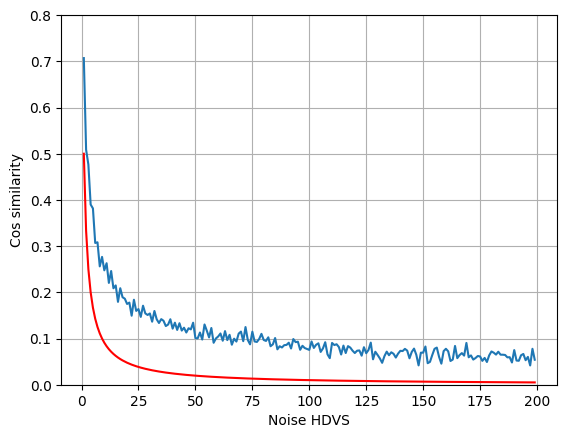

In [51]:
signal_hdv = hdc()
points = list(range(1, 200))
values = []
theoretical_snr = []

for x in points:
    noise_hdvs = hdc(x + 1)[:x]
    b = hdc.bundle([signal_hdv] + list(noise_hdvs))
    sim = hdc.sim(signal_hdv, b)
    values.append(xp_array_from_gpu(sim))
    theoretical_snr.append(1/(1+x))

#plt.bar(points, values)
plt.plot(points, values)
plt.xlabel('Noise HDVS')
plt.ylabel('Cos similarity')
#ax2 = plt.gca().twinx()
#ax2.plot(points, theoretical_snr, '-r')
plt.plot(points, theoretical_snr, '-r')
plt.ylim(0, 0.8)
plt.grid()
plt.show()

In [52]:
x1 = hdc()
x2 = hdc()
bundle = hdc.bundle(x1, x2)
z = hdc.debundle(bundle, x2)
hdc.sim(z, x1), hdc.sim(z, x2)

(array(0.70462756), array(-0.70462756))

In [53]:
hdv_array = HdvArray(10000, xp)
reference = dict(enumerate(hdc(100)))
leased_indices = dict()

assert np.all(hdv_array.array == 0)

for i in reference.keys():
    leased_i = hdv_array.lease()
    assert np.all(hdv_array.array[leased_i] == 0)
    leased_indices[leased_i] = i
    hdv_array.array[leased_i] = reference[i]

for leased_i, reference_i in leased_indices.items():
    assert np.array_equal(hdv_array.array[leased_i], reference[reference_i])
    hdv_array.release(leased_i)

for leased_i in leased_indices.keys():
    assert np.all(hdv_array.array[leased_i] == 0)

assert np.all(hdv_array.array == 0)
leased_indices.clear()

for i in np.random.default_rng().choice(list(reference.keys()), len(reference) // 2, replace=False):
    leased_i = hdv_array.lease()
    assert np.all(hdv_array.array[leased_i] == 0)
    leased_indices[leased_i] = i
    hdv_array.array[leased_i] = reference[i]

for leased_i, reference_i in leased_indices.items():
    assert np.array_equal(hdv_array.array[leased_i], reference[reference_i])
    hdv_array.release(leased_i)

for leased_i in leased_indices.keys():
    assert np.all(hdv_array.array[leased_i] == 0)

In [54]:
x1 = hdc()
x2 = hdc()
x3 = hdc()

bundle1 = hdc.bundle(x1, x2, x3)
bundle2 = hdc.bundle(hdc.bundle(x1, x2), x3)
assert not np.array_equal(bundle1, bundle2)
hdc.sim(x1, bundle1), hdc.sim(x2, bundle1), hdc.sim(x3, bundle1), hdc.sim(x1, bundle2), hdc.sim(x2, bundle2), hdc.sim(x3, bundle2)

(array(0.5002),
 array(0.5004),
 array(0.5098),
 array(0.29360655),
 array(0.29383674),
 array(0.86884981))

In [55]:
x1 = hdc()